In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import urllib
from PIL import Image
from bs4 import BeautifulSoup
import requests
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_predict


In [4]:
movies_df = pd.read_csv('shuffled_movie_df.csv')

movies_df

,Movie Name,Poster Image Link,Synopsis,Genre,IMDb_id,Plot Keywords,Storyline,Genre Variations
0,Big Fish,https://m.media-amazon.com/images/M/MV5BMTYyMz...,A frustrated son tries to determine the fa...,Adventure,tt0319061,fish father son relationship death of father f...,United Press International journalist Will...,Adventure Drama Fantasy
1,Scott Pilgrim vs. the World,https://m.media-amazon.com/images/M/MV5BMTkwNT...,Scott Pilgrim must defeat his new girlfrie...,Action,tt0446029,toronto canada sexy woman cleavage panties sca...,Scott Pilgrim plays in a band which aspire...,Action Comedy Fantasy
2,The Paleface,https://m.media-amazon.com/images/M/MV5BOGZhMG...,Calamity Jane is despatched to find out wh...,Western,tt0040679,comedy of errors misunderstanding punched in t...,Someone is selling guns to the Indians and...,Comedy Family Western
3,How the West Was Won,https://m.media-amazon.com/images/M/MV5BNTk2ND...,A family saga covering several decades of ...,Western,tt0056085,ulysses s. grant character abraham lincoln cha...,Setting off on a journey to the west in th...,Western
4,The Butterfly Effect,https://m.media-amazon.com/images/M/MV5BODNiZm...,Evan Treborn suffers blackouts during sign...,Sci-Fi,tt0289879,love butterfly effect child pornography time t...,Evan Treborn grows up in a small town with...,Drama Sci-Fi Thriller
5,Mrs. Doubtfire,https://m.media-amazon.com/images/M/MV5BMjExMD...,"After a bitter divorce, an actor disguises...",Comedy,tt0107614,male actor playing a female character profanit...,Eccentric actor Daniel Hillard is an amusi...,Comedy Drama Family
6,Indiana Jones and the Last Crusade,https://m.media-amazon.com/images/M/MV5BMjNkMz...,"In 1938, after his father Professor Henry ...",Adventure,tt0097576,holy grail map leap of faith obsession adolf h...,An art collector appeals to Jones to embar...,Action Adventure
7,The Curious Case of Benjamin Button,https://m.media-amazon.com/images/M/MV5BNjQ0NT...,"Tells the story of Benjamin Button, a man ...",Romance,tt0421715,premature aging deformed baby older man younge...,On the day that Hurricane Katrina hits New...,Drama Fantasy Romance
8,Allied,https://m.media-amazon.com/images/M/MV5BZWEyMz...,"In 1942, a Canadian intelligence officer i...",War,tt3640424,nazi spy suicide french german spy,"In the middle of World War II, in turbulen...",Action Drama Romance
9,Paradise Now,https://m.media-amazon.com/images/M/MV5BNDI5OD...,Two childhood friends are recruited for a ...,War,tt0445620,martyr settler friend betrayal fate,"Palestinians Said and Khaled, now in young...",Crime Drama Thriller


# Introduction to the File:
In this file, we use build a machine learning model with the Tfidf on text of Synopsis as features to predict the movie Genre. We try to find the optimal k value for such a model.

#### NOTE:  <br>"Genre Variations" is a column containing all the genres of the movie since the movie can have multiple genres. <br> "Genre" is the most prominent genre of the movie i.e. for example, a movie can be more sci-fi than it is horror such as the movie "Alien"). Hence, we made our own function for finding accuracy and F1 scores.<br> For us, the machine learning model predicts "correctly" if the genre it predicts matches one of the genres from the "Genre Variations" column in the data frame. Hence, we made our own Accuracy function and F1 Score function to reflect this.


####  NOTE: this model we explore here is different from the model we create in ML_1 in that we use another cv value in cross validation on our model using tfidf on text from Synopsis to find another good k value. in ML_4, we combine both models models using tfidf on text from Synopsis with two different optimal k values we found.

#### NOTE: in this file, we deal with test/validation accuracy and test/validation f1 score, not training metrics for classifiers.

###### building the TFIDF data frame to use for the machine learning model

In [5]:

bag_of_words = (
    movies_df["Synopsis"].
    str.lower().
    str.replace("[^A-Za-z\s]", "").
    str.split()
).apply(Counter)

tf = pd.DataFrame(list(bag_of_words)).fillna(0)
df = (tf > 0).sum(axis=0)
idf = np.log(len(tf) / df)
tf_idf = tf * idf
#tf_idf = tf_idf[words]
tf_idf

words = tf_idf.columns
tf_idf["Genre"] = movies_df["Genre"]
tf_idf["Genre Variations"] = movies_df["Genre Variations"]
tf_idf.head()



,a,abagnale,abandoned,abandons,abducted,abductees,abducts,aberration,abilities,ability,...,zion,zodiac,zombie,zombiefilled,zombies,zone,zorg,zubrowka,Genre,Genre Variations
0,0.191821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Adventure,Adventure Drama Fantasy
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Action,Action Comedy Fantasy
2,0.191821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Western,Comedy Family Western
3,0.191821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Western,Western
4,0.383642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sci-Fi,Drama Sci-Fi Thriller


###### Finding which k value optimizes Accuracy
We find that k = 2 optimizes the accuracy for our model here.

21    0.525455
19    0.526364
20    0.533636
1     0.534545
2     0.535455
dtype: float64

1     0.534545
2     0.535455
3     0.492727
4     0.498182
5     0.490000
6     0.483636
7     0.492727
8     0.491818
9     0.498182
10    0.495455
dtype: float64

34    0.507273
35    0.498182
36    0.497273
37    0.512727
38    0.509091
39    0.504545
40    0.506364
41    0.505455
42    0.506364
43    0.503636
44    0.506364
45    0.507273
dtype: float64



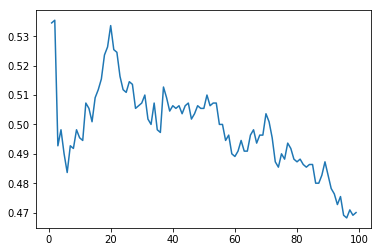

In [6]:
def getAccuracy(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    accuracy = 0
    accuracy1 = 0
    for i in range(0, len(predicted), 1):
        if predicted[i] in  y_genres_list[i]:
            accuracy += 1
    return accuracy/len(y_all_genres)
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getAccuracy)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()


For F1 scores, we print the top 5 k values which give the highest F1 score for that genre <br> After observing all the F1 scores for every genre, I have noticed, most of the time, the k value that optmizes F1 score lies between 1 and 10 and between 33 and 45. So I print the F1 scores asssociated with those k values below also. <br>Analyzising these, I determine the best overall k value in the end.

After analyzing all the K values, we found that the best overall k-value to use either k = 2 or k = 40 which return some of the top F1 scores for each genre. So, I mainly compare between the F1 scores of k = 2 and k = 40.


###### Finding k value that optmizes F1 score for Horror
K = 17 optimizes the f1 score for horror with a score of 47%. However, K = 2 gives an f1 score of 44% which is close to 47%. However, K = 40 gives an f1 score of 40% which is even lower than what k = 2 produces. Hence, K = 2 would be a better choice for Horror.

21    0.464912
18    0.465753
14    0.466368
20    0.466368
17    0.470588
dtype: float64

1     0.376238
2     0.444444
3     0.420513
4     0.463158
5     0.415459
6     0.447489
7     0.437500
8     0.408889
9     0.436019
10    0.441176
dtype: float64

34    0.424242
35    0.403433
36    0.406926
37    0.421053
38    0.436681
39    0.422414
40    0.403433
41    0.420601
42    0.418803
43    0.417021
44    0.434043
45    0.430380
dtype: float64



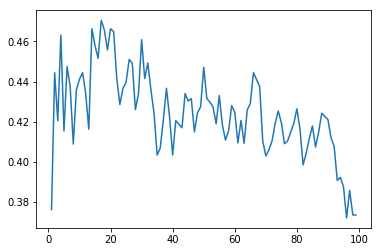

In [8]:
def getF1Horror(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Horror"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Horror)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Action
K = 3 optimizes the f1 score for horror with a score of 47.3%. However, K = 2 gives an f1 score of 46.7% which is close to 47.3%. However, K = 40 gives an f1 score of 28.9% which is far away from 47.3%. Hence, K = 2 would be the best here.

10    0.412417
4     0.445312
5     0.448000
2     0.467091
3     0.474187
dtype: float64

1     0.318538
2     0.467091
3     0.474187
4     0.445312
5     0.448000
6     0.388060
7     0.387665
8     0.386364
9     0.402655
10    0.412417
dtype: float64

34    0.306931
35    0.291457
36    0.300752
37    0.293532
38    0.282116
39    0.292929
40    0.288608
41    0.285714
42    0.279070
43    0.265625
44    0.278351
45    0.248705
dtype: float64



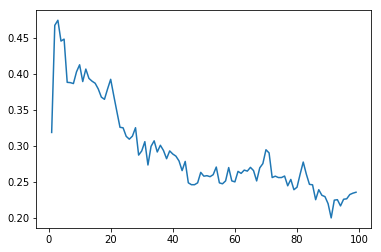

In [9]:
def getF1Action(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Action"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Action)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Adventure
K = 3 optimizes the f1 score for horror with a score of 48.1%. However, K = 40 gives an f1 score of 23.8% which is far away from 48.1%. Hence, K = 2 would be the best here.

5    0.322115
4    0.375566
1    0.405063
3    0.414687
2    0.481400
dtype: float64

1     0.405063
2     0.481400
3     0.414687
4     0.375566
5     0.322115
6     0.313924
7     0.291005
8     0.288660
9     0.282828
10    0.275510
dtype: float64

34    0.247253
35    0.252747
36    0.239554
37    0.261580
38    0.251366
39    0.229050
40    0.238889
41    0.250000
42    0.268097
43    0.279683
44    0.295515
45    0.292553
dtype: float64



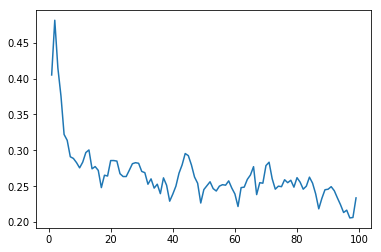

In [10]:
def getF1Adventure(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Adventure"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Adventure)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Romance
K = 79 optimizes the f1 score for horror with a score of 49.8%. K = 2 gives an f1 score of 27% which is far away from 49.8%. However, K = 40 gives an f1 score of 46.6% which is pretty close to 49.8%. Hence, K = 40 would be the better than K = 2 here.

78    0.490066
87    0.490196
77    0.493421
80    0.496689
79    0.498339
dtype: float64

1     0.424460
2     0.270492
3     0.326531
4     0.352000
5     0.349810
6     0.345865
7     0.357414
8     0.339483
9     0.339623
10    0.352490
dtype: float64

34    0.464164
35    0.441379
36    0.430556
37    0.440559
38    0.460993
39    0.457143
40    0.466431
41    0.450704
42    0.470175
43    0.442857
44    0.425993
45    0.425993
dtype: float64



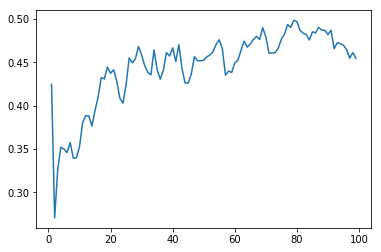

In [11]:
def getF1Romance(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Romance"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Romance)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Comedy
K = 2 optimizes the f1 score for horror with a score of 42.4%. However, K = 40 gives an f1 score of 30% which is far away from 42.4%. Hence, K = 2 would be the best here.

17    0.338558
23    0.347541
22    0.355263
1     0.360544
2     0.423913
dtype: float64

1     0.360544
2     0.423913
3     0.324176
4     0.338028
5     0.306250
6     0.280374
7     0.307229
8     0.320475
9     0.317073
10    0.307692
dtype: float64

34    0.268551
35    0.287671
36    0.266212
37    0.273973
38    0.276094
39    0.286667
40    0.308197
41    0.318182
42    0.297030
43    0.290429
44    0.288591
45    0.313993
dtype: float64



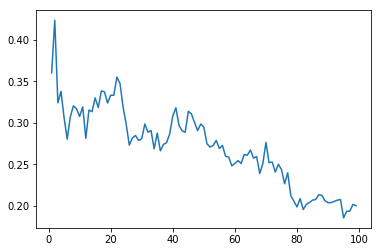

In [12]:
def getF1Comedy(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Comedy"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Comedy)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Sci-Fi
K = 90 optimizes the f1 score for horror with a score of 48.6%. K = 2 gives an f1 score of 25.5% which is far away from 48.6%. However, K = 40 gives an f1 score of 44.6% which is a lot closer to 48.6%. Hence, K = 40 would be the better than K = 2 here.

60    0.482270
55    0.482759
54    0.484429
56    0.486301
90    0.486301
dtype: float64

1     0.368627
2     0.255507
3     0.238095
4     0.306306
5     0.314894
6     0.323077
7     0.343511
8     0.382813
9     0.354331
10    0.389313
dtype: float64

34    0.448276
35    0.442105
36    0.442105
37    0.459364
38    0.463158
39    0.441281
40    0.446809
41    0.435714
42    0.460432
43    0.446043
44    0.448529
45    0.473118
dtype: float64



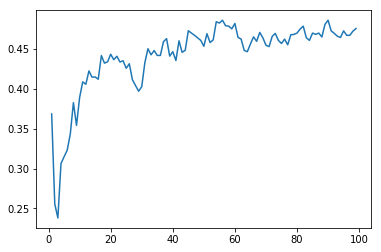

In [13]:
def getF1SciFi(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Sci-Fi"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1SciFi)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Crime
K = 51 optimizes the f1 score for horror with a score of 44.5%. K = 2 gives an f1 score of 40.3% which is far pretty close to 44.5%. But, K = 40 gives an f1 score of 40.9% which is also close to 44.5%. Hence, K = 2 and k = 40 would both be good here.

53    0.428184
52    0.436658
27    0.437673
54    0.439024
51    0.445040
dtype: float64

1     0.402204
2     0.403023
3     0.309783
4     0.327684
5     0.352273
6     0.350282
7     0.374656
8     0.350000
9     0.366577
10    0.360313
dtype: float64

34    0.408964
35    0.391061
36    0.408964
37    0.412429
38    0.407932
39    0.417827
40    0.409091
41    0.412607
42    0.398860
43    0.406685
44    0.397790
45    0.404372
dtype: float64



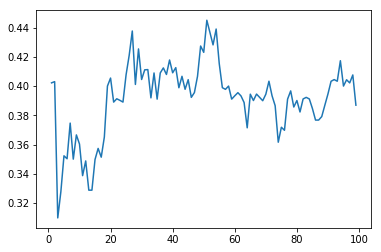

In [14]:
def getF1Crime(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Crime"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Crime)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for War
K = 45 optimizes the f1 score for horror with a score of 46.8%. K = 2 gives an f1 score of 19.8% which is a lot lower than 46.8%. However, K = 40 gives an f1 score of 43.4% which is a lot closer to 46.8%. Hence, K = 40 would be the better than K = 2 here.

46    0.457447
52    0.457447
51    0.464865
47    0.465608
45    0.468085
dtype: float64

1     0.258503
2     0.191489
3     0.283186
4     0.285714
5     0.312057
6     0.340426
7     0.338028
8     0.361111
9     0.424658
10    0.429530
dtype: float64

34    0.440678
35    0.434286
36    0.443182
37    0.448087
38    0.445652
39    0.445652
40    0.434783
41    0.434783
42    0.430108
43    0.443243
44    0.455026
45    0.468085
dtype: float64



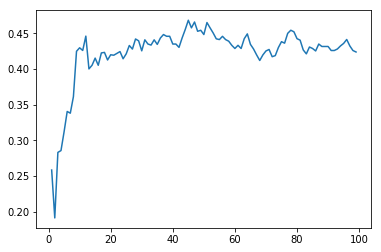

In [18]:
def getF1War(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "War"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1War)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Drama
K = 1 optimizes the f1 score for horror with a score of 19.1%. K = 2 gives an f1 score of 18.2% which is not a lot lower than 19.1%. However, K = 40 gives an f1 score of 10.3% which is a lot lower than 19.1%. Hence, K = 2 would be the better than K = 40 here.

6    0.144272
7    0.149718
3    0.153631
2    0.182313
1    0.190736
dtype: float64

1     0.190736
2     0.182313
3     0.153631
4     0.122682
5     0.123209
6     0.144272
7     0.149718
8     0.138418
9     0.133713
10    0.123033
dtype: float64

34    0.100575
35    0.105563
36    0.102418
37    0.108571
38    0.108883
39    0.106017
40    0.103004
41    0.097143
42    0.094556
43    0.095238
44    0.097842
45    0.100287
dtype: float64



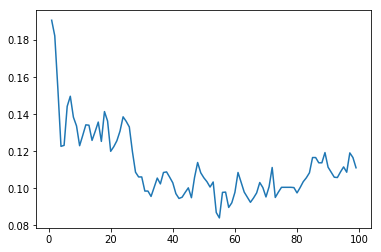

In [16]:
def getF1Drama(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Drama"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Drama)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Thriller
K = 1 optimizes the f1 score for horror with a score of 28.8%. K = 2 gives an f1 score of 9.9% which is a lot lower than 28.8%. However, K = 40 gives an f1 score of 21.2% which is a lot closer to 28.8%. Hence, K = 40 would be the better than K = 2 here.

36    0.215488
59    0.215488
30    0.216949
37    0.236486
1     0.288235
dtype: float64

1     0.288235
2     0.098859
3     0.073469
4     0.114504
5     0.139860
6     0.142349
7     0.135231
8     0.156028
9     0.166090
10    0.150000
dtype: float64

34    0.211604
35    0.214765
36    0.215488
37    0.236486
38    0.207358
39    0.206667
40    0.211604
41    0.206897
42    0.206897
43    0.215278
44    0.199313
45    0.167832
dtype: float64



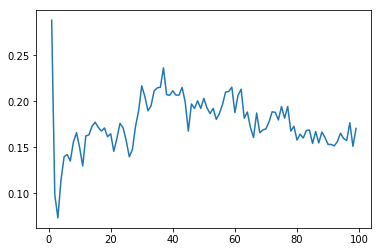

In [17]:
def getF1Thriller(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Thriller"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1Thriller)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

###### Finding k value that optmizes F1 score for Western
K = 45 optimizes the f1 score for horror with a score of 46.8%. K = 2 gives an f1 score of 19.1% which is a lot lower than 46.8%. However, K = 40 gives an f1 score of 43.4% which is a lot closer to 46.8%. Hence, K = 40 would be the better than K = 2 here.

46    0.457447
52    0.457447
51    0.464865
47    0.465608
45    0.468085
dtype: float64

1     0.258503
2     0.191489
3     0.283186
4     0.285714
5     0.312057
6     0.340426
7     0.338028
8     0.361111
9     0.424658
10    0.429530
dtype: float64

34    0.440678
35    0.434286
36    0.443182
37    0.448087
38    0.445652
39    0.445652
40    0.434783
41    0.434783
42    0.430108
43    0.443243
44    0.455026
45    0.468085
dtype: float64



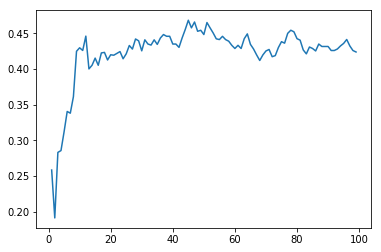

In [19]:
def getF1Western(k):
    
    X_train = tf_idf[words]
    y_train = tf_idf["Genre"]

    y_all_genres = tf_idf["Genre Variations"]

    model = KNeighborsClassifier(n_neighbors=k, metric = "cosine")
    #pipeline = Pipeline([("scaler", scaler), ("model", model)])
    pipeline = Pipeline([("model", model)])
    predicted = cross_val_predict(model, X_train, y_train, cv=5)

    #print(len(list(y_train)))
    #print(len(list(predicted)))
    #list(predicted)

    y_genres_list = list(y_all_genres)
    y_train_list = list(y_train)
    predicted_list = list(predicted)

    cur_genre = "Western"
    precision_denominator = 0
    recall_denominator = 0
    true_positives = 0
    
    
    for i in range(0, len(predicted), 1):
        if predicted[i] == cur_genre and cur_genre in y_genres_list[i]:
               true_positives += 1
        if predicted[i] == cur_genre:
            precision_denominator += 1
        if cur_genre in y_genres_list[i]:
            recall_denominator += 1
    precision = true_positives / precision_denominator
    recall =  true_positives / recall_denominator
    
    return (2 * precision * recall / (precision + recall))
    
    
    
ks = pd.Series(range(1, 100, 1))
ks.index = range(1, 100, 1)
errors = ks.apply(getF1War)
errors.plot.line()
errors.idxmax()
print(errors.sort_values()[-5:])
print()
print(errors[0:10])
print()
print(errors[33:45])
print()

### Conclusion on what is the best K value to use for this model

Above after looking at the top optimal k values and even seeing the graphs, I have noticed that the best k value usually lies within 1 and 10 or within 33 and 45 all inclusive. Narrowing it down to numbers between these two ranges, I noticed the K values that yeild high F1 scores constantly for most genres is K = 2 and K = 40. Hence I compared K = 2 and K = 40 F1 scores for all genres.

From the results above, we have concluded K = 2 would be better for Accuracy, Horror, Action, Adventure, Comedy, and Drama while k = 40 would be better for Romance, Sci-Fi, War, Thriller, Western. Hence, because K = 2 is better for a higher number of genres, it is best to use K = 2 instead of K = 40 in our model.  